### Data Quality and Cleaning

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [35]:
df = pd.read_csv("../data/raw/heart_disease_data.csv")

In [36]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [37]:
y = df['HeartDisease'].values
X = df.drop('HeartDisease', axis=1)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=RANDOM_SEED, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=RANDOM_SEED, test_size=0.25)

In [38]:
NUMERIC_FEATURES = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
CATEGORICAL_FEATURES = ['Sex', 'ChestPainType', 'RestingECG', 'ST_Slope', 'ExerciseAngina']
BINARY_FEATURES = ['FastingBS']
TARGET = 'HeartDisease'

#### Numerical Feature Analysis

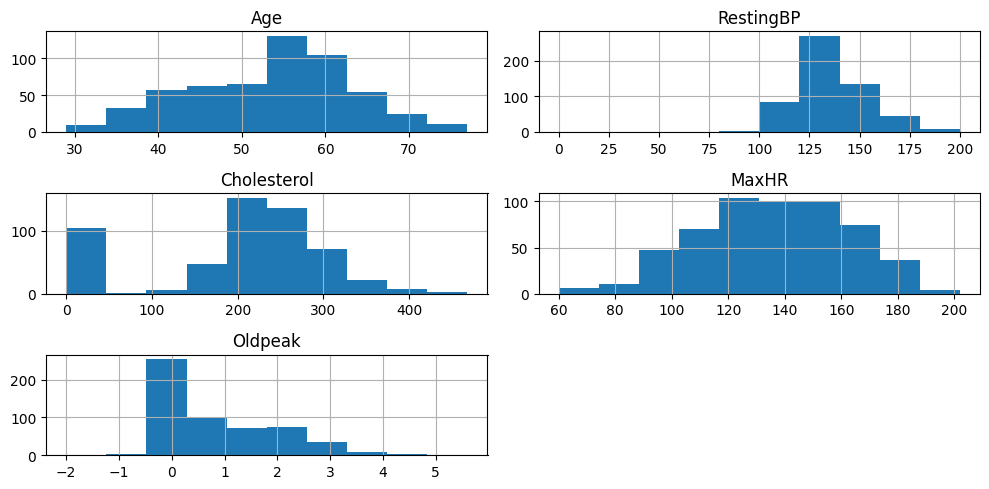

In [39]:
#Cholestrol has large # of 0s that need to be filled, Data quality issue
#RestingBP, Age, MaxHR roughly normal distribution
# OldPeak is skewed and needs to be log transformed

X_train[NUMERIC_FEATURES].hist(figsize=(10,5))
plt.tight_layout()
plt.show()

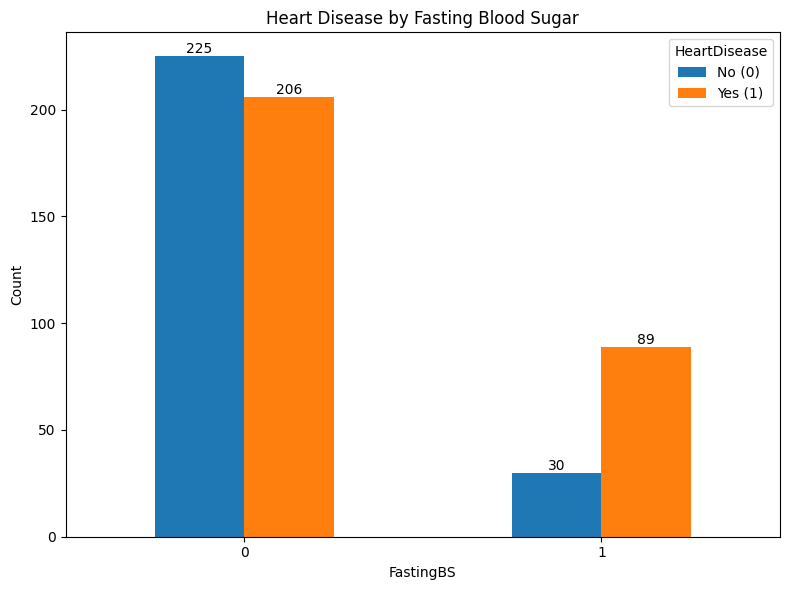

In [40]:
## Fasting Blood Sugar - Imbalanced ; Blood Sugar Fasting tests can yield higher heart disease (check for correlated features)

crosstab = pd.crosstab(X_train['FastingBS'], y_train)

ax = crosstab.plot(kind='bar', figsize=(8,6))
plt.xlabel('FastingBS')
plt.ylabel('Count')
plt.title('Heart Disease by Fasting Blood Sugar')
plt.legend(title='HeartDisease', labels=['No (0)', 'Yes (1)'])
plt.xticks(rotation=0)
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.tight_layout()
plt.show()

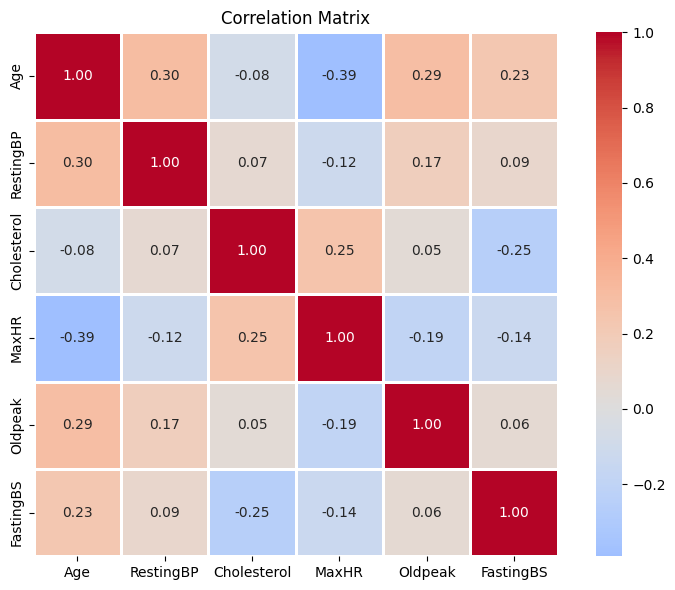

In [41]:
## Max Heart Rate has the highest absolute correlation with Heart Disease, the higher the max rate the less likely they are to have heart disease
## OldPeak also has 0.4 absolute correlation with Heart Disease , the higher the magnitude of reduced blood flow to the hear, the more likely the patient is to have heart disease
all_num_features = NUMERIC_FEATURES + BINARY_FEATURES

corr_matrix = X_train[all_num_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

#### Categorical Feature Analysis

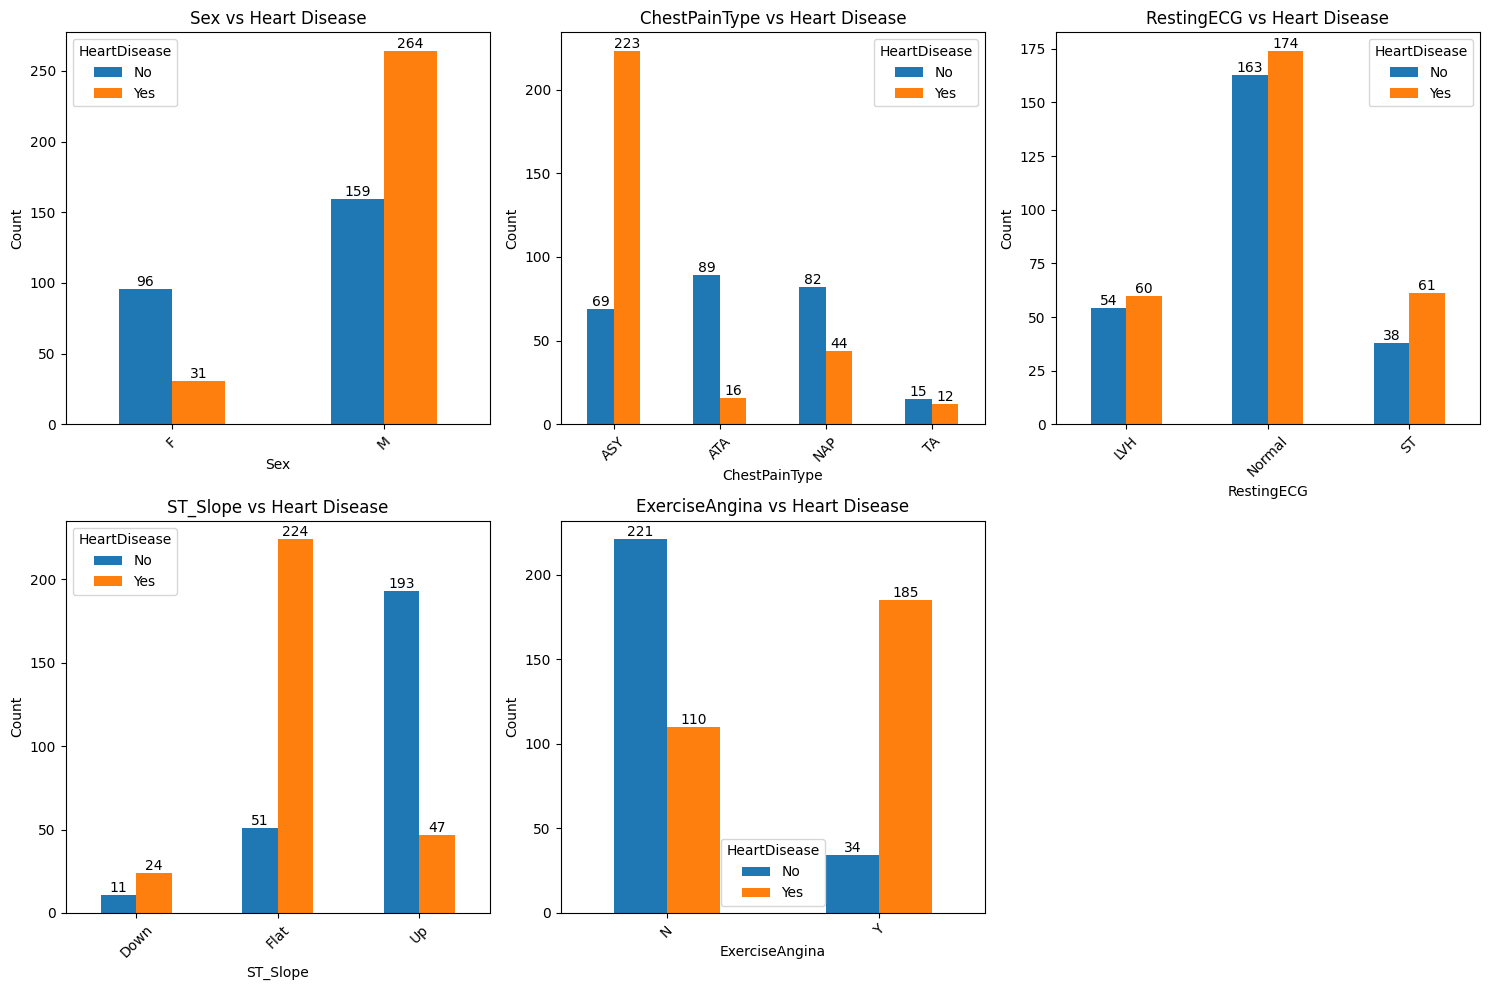

In [42]:
# ChestPainType, ST_Slope, and ExerciseAngine has the biggest impact on Heart Disease
# Also, the sample population is heavily skewed towards male heart disease patients

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(CATEGORICAL_FEATURES):
    ct = pd.crosstab(X_train[col], y_train)
    ct.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'{col} vs Heart Disease')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='HeartDisease', labels=['No', 'Yes'])
    axes[i].tick_params(axis='x', rotation=45)
    
    for container in axes[i].containers:
        axes[i].bar_label(container)

axes[-1].set_visible(False)
plt.tight_layout()
plt.show()

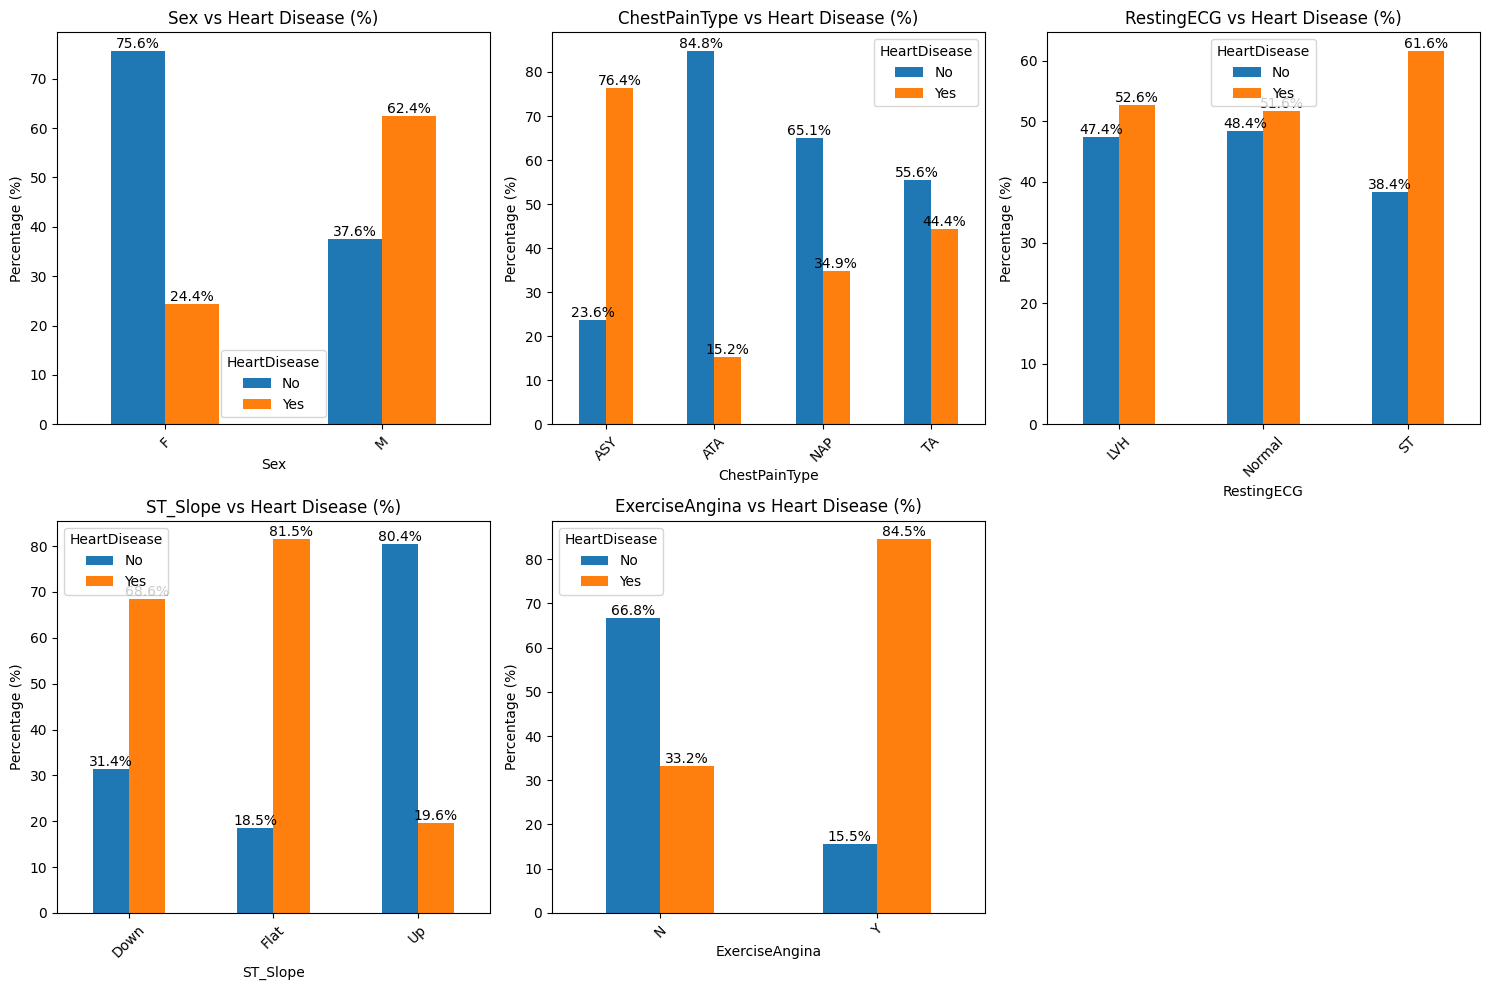

In [43]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(CATEGORICAL_FEATURES):
    # Normalize by rows (within each category)
    ct = pd.crosstab(X_train[col], y_train, normalize='index') * 100
    ct.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'{col} vs Heart Disease (%)')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Percentage (%)')
    axes[i].legend(title='HeartDisease', labels=['No', 'Yes'])
    axes[i].tick_params(axis='x', rotation=45)
    
    # Add percentage labels
    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%.1f%%')

axes[-1].set_visible(False)
plt.tight_layout()
plt.show()

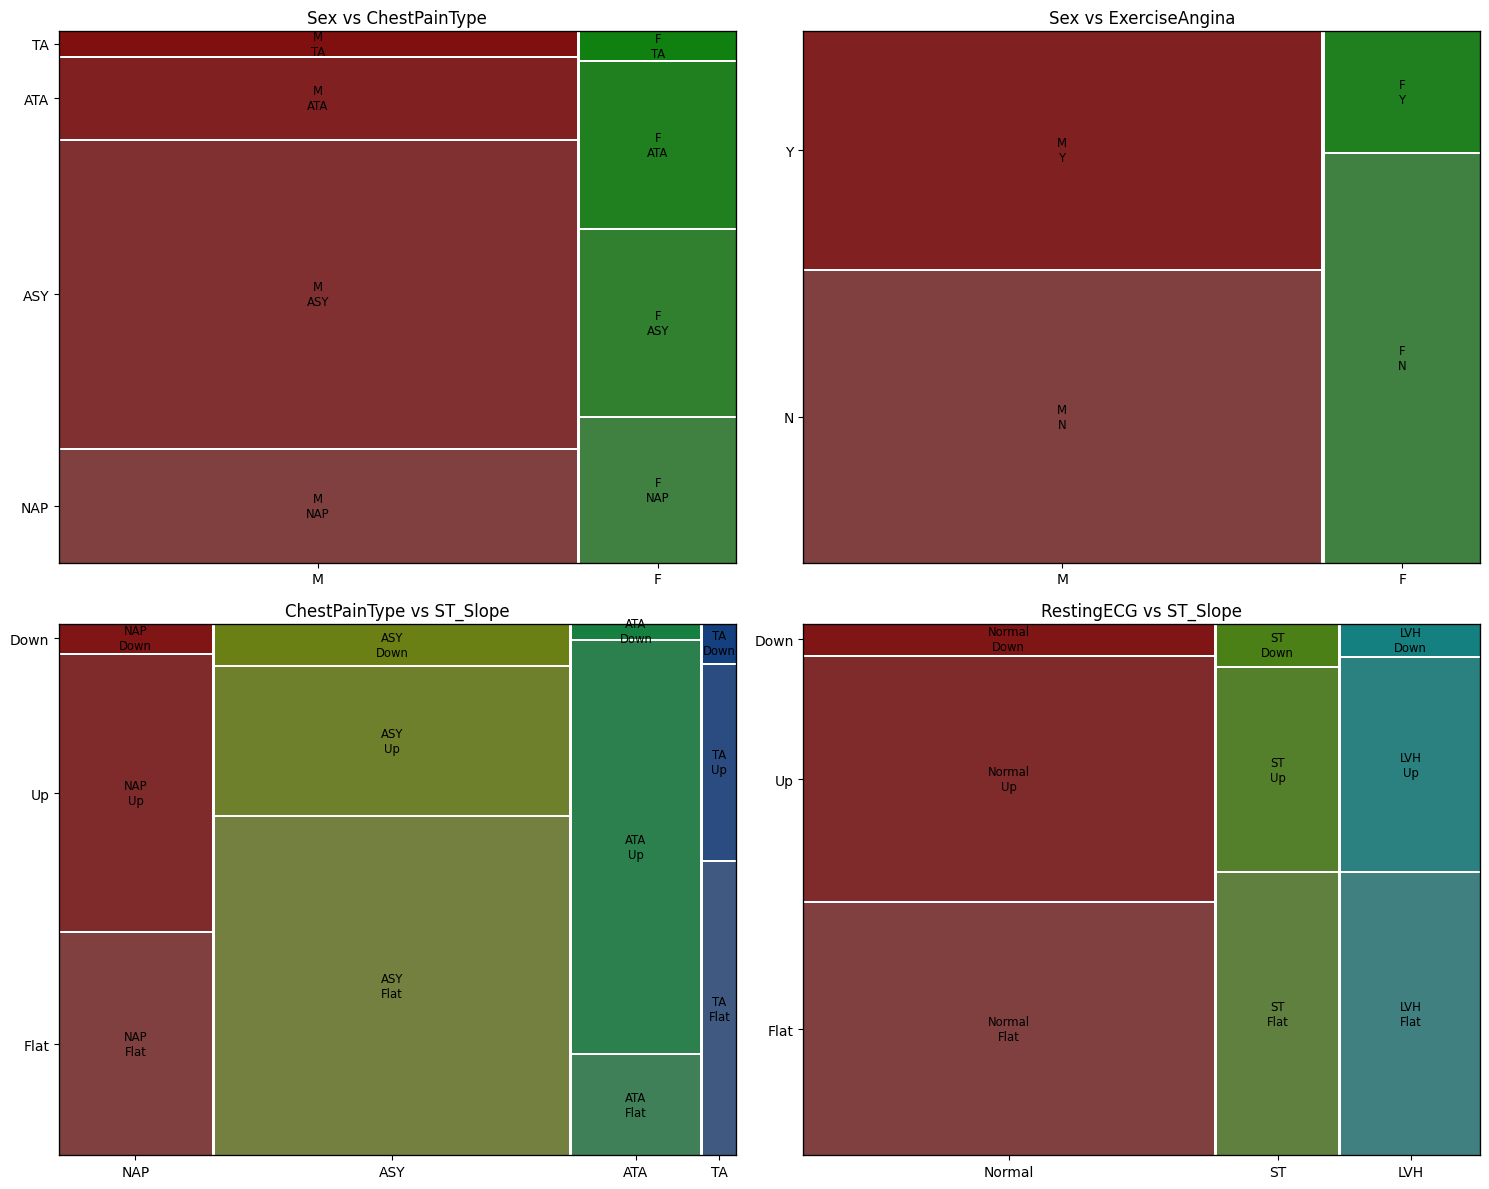

In [44]:
## Most observations are from male patients suffering from Angina Chest Pain
from statsmodels.graphics.mosaicplot import mosaic

ig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

combinations = [
    ('Sex', 'ChestPainType'),
    ('Sex', 'ExerciseAngina'),
    ('ChestPainType', 'ST_Slope'),
    ('RestingECG', 'ST_Slope')
]

for i, (col1, col2) in enumerate(combinations):
    mosaic(X_train, [col1, col2], ax=axes[i], title=f'{col1} vs {col2}')

plt.tight_layout()
plt.show()

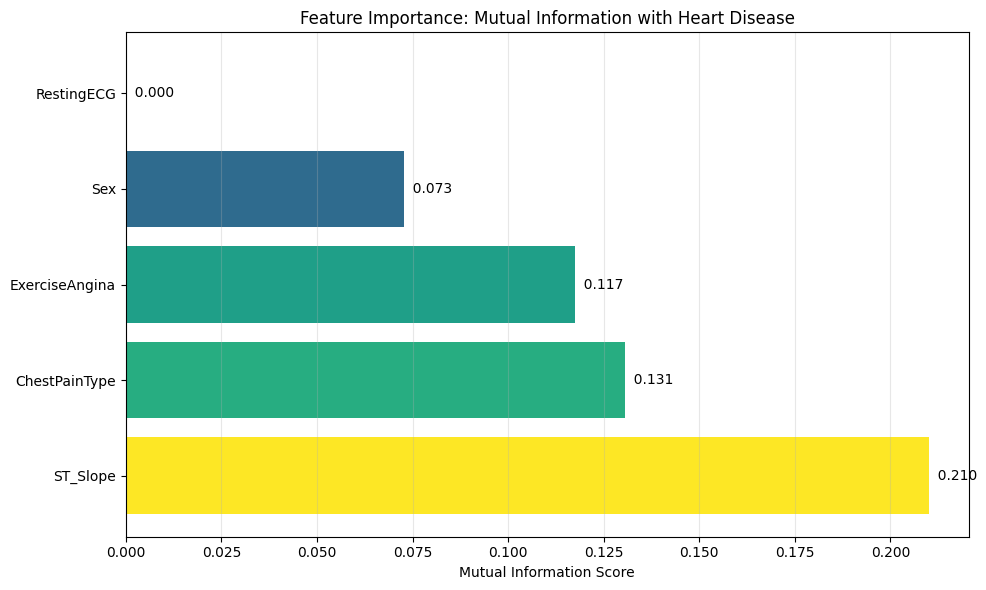

In [45]:
# ST_Slop has strongest relationship with Heart Disease

X_encoded = X_train[CATEGORICAL_FEATURES].apply(LabelEncoder().fit_transform)
mi_scores = mutual_info_classif(X_encoded, y_train, random_state=42)

# Create ranked DataFrame
mi_df = pd.DataFrame({
    'Feature': CATEGORICAL_FEATURES,
    'MI_Score': mi_scores,
    'Rank': range(1, len(CATEGORICAL_FEATURES) + 1)
}).sort_values('MI_Score', ascending=False).reset_index(drop=True)

mi_df['Rank'] = range(1, len(mi_df) + 1)

plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(mi_df['MI_Score'] / mi_df['MI_Score'].max())
bars = plt.barh(mi_df['Feature'], mi_df['MI_Score'], color=colors)
plt.xlabel('Mutual Information Score')
plt.title('Feature Importance: Mutual Information with Heart Disease')
plt.grid(axis='x', alpha=0.3)

for i, (feat, score) in enumerate(zip(mi_df['Feature'], mi_df['MI_Score'])):
    plt.text(score, i, f'  {score:.3f}', va='center')

plt.tight_layout()
plt.show()